In [15]:
from scipy.stats import cauchy
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle

# Download Example Macro Strategy Returns 

In [2]:
path = r'C:\Users\marcu\Documents\Profession\Windermere Capital\Macro Model\NN Macro Strategy Backtests\pred_5_t_filter_3_view_0\macro_backtest_rebal_freq_10_reg_lookback_60.pickle'

with open(path, 'rb') as handler:
    backtest = pickle.load(handler)

strategy_returns = backtest['Strategy Returns 0']

# Download Example SPY Returns

In [86]:
assets = ['SPY']
asset_returns = pd.DataFrame()

for ticker in assets:
    prices = yf.download(ticker, start='1997-01-01', end='2022-11-21')['Adj Close']
    # Shift yesterday's prices forward to compute log returns
    rets = np.log(prices/prices.shift(1)).dropna()
    rets = rets.rename(ticker)
    asset_returns = pd.concat([asset_returns, rets], axis=1)
    break

strategy_returns = asset_returns.iloc[:,0]

[*********************100%***********************]  1 of 1 completed


# Model specified returns with Normal, Laplace, & Cauchy distributions

In [93]:
mu = strategy_returns.mean() # will be used as a crude approximation of location for distributions (in reality, location must be computed uniquely for each type of distribution)
sigma = strategy_returns.std() # will be used as a crude approximation of scale for distributions (in reality, scale must be computed uniquely for each type of distribution)
N = 10000 #len(strategy_returns)

# Simulate Cauchy Distribution
sample_cauchy = cauchy.rvs(loc = mu, scale = sigma, size = N)
# Must constrain Cauchy Distribution as the true tails of this distribution are unrealistic
# This is heuristically executed using 97.5% confidence levels as a cutoff... may be altered once I compute location and scale formulaically (again, these are only approximations)
sample_cauchy = sample_cauchy[sample_cauchy>np.percentile(sample_cauchy, 2.5)]
sample_cauchy = sample_cauchy[sample_cauchy<np.percentile(sample_cauchy, 97.5)]

# Simulate Laplace Distribution
sample_laplace = np.random.laplace(loc = mu, scale = sigma, size = N)

# Simulate Normal Distribution
sample_norm = np.random.normal(loc = mu, scale = sigma, size = N)

Plot simulations' histograms with sample returns

(array([  1.,   0.,   3.,   2.,   3.,   5.,   5.,  19.,  23.,  43.,  60.,
         70.,  90., 137., 154., 188., 254., 292., 368., 377., 484., 493.,
        546., 583., 566., 611., 581., 581., 538., 457., 446., 394., 342.,
        273., 270., 184., 144., 114.,  80.,  72.,  45.,  30.,  33.,  14.,
          8.,   7.,   3.,   4.,   1.,   2.]),
 array([-0.04685055, -0.04499216, -0.04313377, -0.04127538, -0.03941698,
        -0.03755859, -0.0357002 , -0.03384181, -0.03198341, -0.03012502,
        -0.02826663, -0.02640824, -0.02454984, -0.02269145, -0.02083306,
        -0.01897467, -0.01711627, -0.01525788, -0.01339949, -0.0115411 ,
        -0.0096827 , -0.00782431, -0.00596592, -0.00410753, -0.00224913,
        -0.00039074,  0.00146765,  0.00332604,  0.00518444,  0.00704283,
         0.00890122,  0.01075961,  0.01261801,  0.0144764 ,  0.01633479,
         0.01819318,  0.02005158,  0.02190997,  0.02376836,  0.02562675,
         0.02748515,  0.02934354,  0.03120193,  0.03306032,  0.03491872,
 

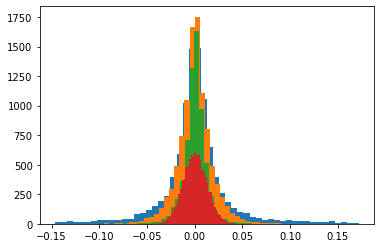

In [94]:
plt.hist(sample_cauchy, 50)
plt.hist(sample_laplace, 50)
plt.hist(strategy_returns, 50)
plt.hist(sample_norm, 50)

# Get worst daily returns and 95%/99% worst returns for all distributions

It is evident that Laplace captures the dynamics of financial returns' tails very well. 
It is reckless to simply rely on CLM (assuming normality as N approaches inf) when it comes to return distributions, even if we are considering log-normal distributions.

In [99]:
print('5 worst returns: \n', strategy_returns.nsmallest(5))
print('5th percentile of returns:', np.percentile(strategy_returns, 5))
print('1st percentile of returns:', np.percentile(strategy_returns, 1))

5 worst returns: 
 2020-03-16   -0.115887
2008-10-15   -0.103637
2020-03-12   -0.100569
2008-12-01   -0.092749
2008-09-29   -0.081603
Name: SPY, dtype: float64
5th percentile of returns: -0.01981724692068839
1st percentile of returns: -0.03514554805723609


In [104]:
print('5 worst returns: \n', pd.Series(sample_laplace).nsmallest(5))
print('5th percentile of returns:', np.percentile(sample_laplace, 5))
print('1st percentile of returns:', np.percentile(sample_laplace, 1))

5 worst returns: 
 500    -0.132735
8473   -0.131559
7815   -0.107743
4103   -0.102714
3483   -0.094151
dtype: float64
5th percentile of returns: -0.029715806095052113
1st percentile of returns: -0.05028309309373325


In [105]:
print('5 worst returns: \n', pd.Series(sample_cauchy).nsmallest(5))
print('5th percentile of returns:', np.percentile(sample_cauchy, 5))
print('1st percentile of returns:', np.percentile(sample_cauchy, 1))

5 worst returns: 
 8485   -0.146679
8685   -0.146562
6884   -0.146401
3428   -0.145986
3028   -0.145859
dtype: float64
5th percentile of returns: -0.052702610181769964
1st percentile of returns: -0.10991904362961953


# To solve for this mediocre approximation of financial returns, use MLDP's probabilistic SR:

This essentially captures the fact that SRs are not directly comparable since they assume normality of returns. 
Moreover, SRs do not account for higher statistical moments (skew, kurtosis), thus, omitting key information for the quality of a returns series.

This can radically impact the conclusions made from SRs, and could possible make a smaller SR actually more attractive than a large one for an allocator
(this would be the case if the larger SR is highly negatively skewed).

This will have implications in both portfolio analysis, but potentially more importantly, portfolio construction by altering objective functions beyond max SR... this could be in the form of an economic 
utility function that accounts for higher moments, or more directly, using max probabilistic SR (Marcos Lopez de Prado's finding) as the objective function.



See more at: 
1) https://quantdare.com/probabilistic-sharpe-ratio/
2) https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2146219 - SEC + Wells Fargo Research
3) https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643 - Marco Lopez de Prado

# Next Steps: construct a general error distribution (normal dist with varying skew) via convex opts + PDFs + CDFs + Max Log Likelihood: 

NEDL Video: https://www.youtube.com/watch?v=13_JmWqNr7g